<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS453 - A.1: First Vectorized Representation

For each dataset, we will establish a common corpus-wide vocabulary. This corpus vocabulary is what would represent the content of each different document for clustering and classification purposes, which will be our next step. 

Step 1: Qualitative Approach
To decide on whether or not we will keep a term, we need to know that:

It is important, in at least one (preferably more) documents, and
It is prevalent, in at least two or three of the documents.
As usual, there is a bit of a judgment call involved.

The goal here is to identify terms within your document that you think are good candidates for the corpus vocabulary. Just think about your document, and identify the three or four terms that you'd like to see in a final vector that we'd use for clustering and/or classification.

Summarize your nominations in your Report. 

Step 2: Evaluate Results of Code
Experiment (to the extent that you comfortably can) with the code provided (Pls. check here Download here for the collection of jupyter notebooks that will help), which produces TF-IDF, Word2Vec, Doc2Vec, and ELMo embeddings output. Report on your experiment.

To the best of your ability, see if you can find the actual (code-produced) TF-IDF scores for key terms in your documents.

Do the terms that you think are important actually, have a corpus-wide high-enough TF-IDF so that they warrant inclusion in a vector that would be used for clustering and classification? 

The IMPORTANT thing is that, having developed a bit of intuition about how you think TF-IDF works, see if it bears out when you see actual algorithmic results. 

For example, find the two or three terms (nouns/noun phrases) from your documents that you thought would have the highest TF-IDF, and see if they did indeed have the highest TF-IDF as shown in the algorithmic outputs. 
Similarly, find two or three terms that you thought would have a lower TF-IDF, and see if that bears out. 
Report your results in a short (typically five-page) document (pdf format). Page length is not critical. Express what you've learned as succinctly as possible. 

In the end, summarize your insights about TF-IDF,  Word2Vec / Doc2Vec, and ELMo embeddings, given your assessment of code outputs. 

NOTE:  We include two datasets for this assignment so you get a sense of the complexities that surface given the data you are working with.  Describe the complexities.  Did you find it easier to work with the movie review dataset or the TripAdvisor dataset?

### Hotel Dataset

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML
import pkg_resources
from typing import List, Callable, Dict
import tensorflow_hub as hub
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### NLTK Downloads

In [2]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

## Utility Functions

In [3]:
def add_Hotel_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Description" to the supplied dataframe, in the form {Rating}_{P|N}_{Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Rating'] + '_' + corpus_df['Title'] + '_' + review + '_' + corpus_df['DocID'].astype(str)

def get_corpus_df(path, sheet):
    data = pd.read_excel(path, sheet_name=sheet)
    add_Hotel_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['DocID'])
    indexed_data['DocID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []

    stop_words = set(nltk.corpus.stopwords.words('english'))
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))

    return result

def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)

def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

## Loading the data

In [4]:
data_path='./Data.xlsx'
corpus_df = get_corpus_df(data_path, 'Hotel Reviews')
documents = [Document(x, y) for x, y in zip(corpus_df.DocID, corpus_df.Review)]

In [5]:
corpus_df

,Title,Rating,Review Type,Review,Descriptor,DocID
DocID,,,,,,
8,Chic motel that has a few issues,Average,Negative,The decoration in the rooms is smart and appea...,Average_Chic motel that has a few issues_N_8,8
9,Fall Foliage Trip,Average,Positive,"My husband and I, along with our Papillon Lina...",Average_Fall Foliage Trip_P_9,9
10,Not bad for an older place,Average,Positive,This is an updated older motel. The room was c...,Average_Not bad for an older place_P_10,10
5,A Magical Stay at Sleep Woodstock,High,Positive,I had the most wonderful experience at Sleep W...,High_A Magical Stay at Sleep Woodstock_P_5,5
3,A very nice motel!,High,Positive,We recently stayed at the Sleep Woodstock Mote...,High_A very nice motel!_P_3,3
4,Easy Peasy,High,Positive,My husband and I were stopping overnight in Wo...,High_Easy Peasy_P_4,4
1,Great motel at a grea value.,High,Positive,What a great motel. I love motels for the conv...,High_Great motel at a grea value._P_1,1
2,Perfect way to Start a Vermont Experience,High,Positive,"Room was quiet, clean and so comfortable. Love...",High_Perfect way to Start a Vermont Experience...,2
7,Do Not Stay in Room #6,Low,Negative,The front office wreaked of doggy drool. The d...,Low_Do Not Stay in Room #6_N_7,7


1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploritory Data Analysis

In [6]:
corpus_df.shape

(10, 6)

In [7]:
corpus_df.head(4).T

DocID,8,9,10,5
Title,Chic motel that has a few issues,Fall Foliage Trip,Not bad for an older place,A Magical Stay at Sleep Woodstock
Rating,Average,Average,Average,High
Review Type,Negative,Positive,Positive,Positive
Review,The decoration in the rooms is smart and appea...,"My husband and I, along with our Papillon Lina...",This is an updated older motel. The room was c...,I had the most wonderful experience at Sleep W...
Descriptor,Average_Chic motel that has a few issues_N_8,Average_Fall Foliage Trip_P_9,Average_Not bad for an older place_P_10,High_A Magical Stay at Sleep Woodstock_P_5
DocID,8,9,10,5


In [8]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 8 to 6
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        10 non-null     object
 1   Rating       10 non-null     object
 2   Review Type  10 non-null     object
 3   Review       10 non-null     object
 4   Descriptor   10 non-null     object
 5   DocID        10 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 560.0+ bytes
None


In [9]:
print(corpus_df['Title'].unique())

['Chic motel that has a few issues' 'Fall Foliage Trip'
 'Not bad for an older place' 'A Magical Stay at Sleep Woodstock'
 'A very nice motel!' 'Easy Peasy' 'Great motel at a grea value.'
 'Perfect way to Start a Vermont Experience' 'Do Not Stay in Room #6'
 'Very Disappointed!']


## Number of Reviews By Rating

In [10]:
counts_df = corpus_df[['Rating']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Rating']).count().reset_index()

,Rating,Count
0,Average,3
1,High,5
2,Low,2


In [11]:
corpus_df.columns

Index(['Title', 'Rating', 'Review Type', 'Review', 'Descriptor', 'DocID'], dtype='object')

## Normalized Document

1. remove_punctuation(text)
2. lower_case(text)
3. remove_tags(text)
4. remove_special_chars_and_digits(text)
5. return Document(document.doc_id, text)

In [12]:
normalized_documents = normalize_documents(documents)
normalized_documents[0]

Document(doc_id=8, text='the decoration in the rooms is smart and appealing we really liked our room and the updated vintage feel of the motel in general but the light blocking shades didn t so our room was light all night and the road noise from passing traffic was much louder than we would have expected on a relatively minor country highway the strict no contact policy for check in and afterward seems a bit dated at this point though it probably is better for the motel management from a personnel standpoint it became annoying when i went looking for ice at about pm nearly an hour before the posted pm closure time of the reception room where the ice machine resides and found the room locked and dark i d recommend putting the ice machine someplace more accessible ')

## Standardize Document

#### NLTK Tokenizer Package

https://www.nltk.org/api/nltk.tokenize.html

Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string:

### Functions for Tokenization Process
1. tokenize_document
2. tokenize_documents

In [13]:
tokenized_documents = tokenize_documents(normalized_documents)
tokenized_documents[0]

TokenizedDocument(doc_id=8, tokens=['the', 'decoration', 'in', 'the', 'rooms', 'is', 'smart', 'and', 'appealing', 'we', 'really', 'liked', 'our', 'room', 'and', 'the', 'updated', 'vintage', 'feel', 'of', 'the', 'motel', 'in', 'general', 'but', 'the', 'light', 'blocking', 'shades', 'didn', 't', 'so', 'our', 'room', 'was', 'light', 'all', 'night', 'and', 'the', 'road', 'noise', 'from', 'passing', 'traffic', 'was', 'much', 'louder', 'than', 'we', 'would', 'have', 'expected', 'on', 'a', 'relatively', 'minor', 'country', 'highway', 'the', 'strict', 'no', 'contact', 'policy', 'for', 'check', 'in', 'and', 'afterward', 'seems', 'a', 'bit', 'dated', 'at', 'this', 'point', 'though', 'it', 'probably', 'is', 'better', 'for', 'the', 'motel', 'management', 'from', 'a', 'personnel', 'standpoint', 'it', 'became', 'annoying', 'when', 'i', 'went', 'looking', 'for', 'ice', 'at', 'about', 'pm', 'nearly', 'an', 'hour', 'before', 'the', 'posted', 'pm', 'closure', 'time', 'of', 'the', 'reception', 'room', 'w

## Useful Lookups (Titles by DocID, Ratings by DocID, Description by DocID)

In [14]:
titles_by_doc_ids = {x: y for x, y in zip(corpus_df['DocID'], corpus_df['Title'])}
Ratings_by_doc_ids = {x: y for x, y in zip(corpus_df['DocID'], corpus_df['Rating'])}
descriptors_by_doc_ids = {x: y for x, y in zip(corpus_df['DocID'], corpus_df['Descriptor'])}

action_doc_ids = [int(x) for x in corpus_df['DocID'] if Ratings_by_doc_ids[x] == 'High']
action_documents = [x for x in documents if x.doc_id in action_doc_ids]

non_action_doc_ids = {int(x) for x in corpus_df['DocID'] if Ratings_by_doc_ids[x] != 'Low'}
non_action_documents = [x for x in documents if x.doc_id in non_action_doc_ids]

## Lookup for Specific Movie Title

In [15]:
print(corpus_df['Title'].unique())

['Chic motel that has a few issues' 'Fall Foliage Trip'
 'Not bad for an older place' 'A Magical Stay at Sleep Woodstock'
 'A very nice motel!' 'Easy Peasy' 'Great motel at a grea value.'
 'Perfect way to Start a Vermont Experience' 'Do Not Stay in Room #6'
 'Very Disappointed!']


In [16]:
casino_royale_doc_ids = [int(x) for x in corpus_df['DocID'] if 'motel' in titles_by_doc_ids[x]  ]
casino_royale_documents = [x for x in documents if x.doc_id in casino_royale_doc_ids]

In [17]:
casino_royale_doc_ids

[8, 3, 1]

## Qualitative Term Determinations

#### Terms Determined by Document of Interest

In [18]:
candidate_terms = [
    'cleanliness',
    'comfort',
    'amenities',
    'location',
    'service',
    'check-in',
    'noise',
    'price',
    'bed',
    'staff',
    'bathroom',
    'parking',
    'pet-friendly',
    'renovation',
    'view'
]

## CountVectorizer

<div class="alert alert-block alert-success">
    <b>sklearn.feature_extraction.text.CountVectorizer</b>:<br>
Convert a collection of text documents to a matrix of token counts.<br>
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.<br>
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
</div>

In [19]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df.DocID)

In [20]:
add_flags(word_counts, casino_royale_doc_ids, action_doc_ids)
word_counts['DocID'] = word_counts.index

In [21]:
# Collect result into a dataframe
mean_frequencies = pd.DataFrame(index=candidate_terms)

casino_royale_mean_frequencies = word_counts[word_counts.is_casino_royale][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['Motel'] = casino_royale_mean_frequencies

action_mean_frequencies = word_counts[word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['High'] = action_mean_frequencies

non_action_mean_frequencies = word_counts[~word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['Low'] = non_action_mean_frequencies

In [22]:
mean_frequencies.fillna(0.0).sort_values(['Motel'], ascending=False)

,Motel,High,Low
noise,1.000000,0.6,0.2
bed,0.666667,1.2,0.2
price,0.333333,0.2,0.0
cleanliness,0.000000,0.0,0.0
comfort,0.000000,0.0,0.0
amenities,0.000000,0.4,0.0
location,0.000000,0.0,0.0
service,0.000000,0.0,0.0
check-in,0.000000,0.0,0.0
staff,0.000000,0.4,0.0


In [23]:
# These are identified
important_prevalent_terms = [
    'bathroom',
    'amenities',
    'view',
    'cleanliness'
]
stemmer = PorterStemmer()
stemmed_important_prevalent_terms = [stemmer.stem(x) for x in important_prevalent_terms]

In [24]:
pd.options.display.float_format = '{:,.2f}'.format
mean_frequencies.fillna(0.0).loc[important_prevalent_terms].round(2).sort_values(['Motel'], ascending=False)

,Motel,High,Low
bathroom,0.00,0.20,1.00
amenities,0.00,0.40,0.00
view,0.00,0.00,0.00
cleanliness,0.00,0.00,0.00


## TF-IDF Experiment Functions - Text Normalization

In [27]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              important_prevalent_terms: List[str],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]

    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)
            print(one_doc_as_df)

    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix,
                               columns=vectorizer.get_feature_names_out(),
                               index=corpus_df.DocID)
    add_flags(doc_term_df, casino_royale_doc_ids, action_doc_ids)

    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)

    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)

    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    tfidf_results['All Hotels'] = all_tfidf_results

    plt.hist(doc_term_df.mean(), 100, range=(0, 8))

    print(f'Vocabulary size: {doc_term_df.shape[1]}')

    descriptors = corpus_df['Descriptor']

    similarities = cosine_similarity(doc_term_df.loc[action_doc_ids], doc_term_df.loc[action_doc_ids])
    fig, ax = plt.subplots(figsize=(8, 8))
    labels = [descriptors_by_doc_ids[x.doc_id] for x in action_documents]
    sns.heatmap(ax=ax, data=similarities, xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

## TF-IDF  (Term Frequency-Inverse Document Frequency)

### Experiments, Normalize, Tokenize, Lemmatization and Stop Word Removal

In [28]:
def clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)

    return documents

,Mean TF-IDF
wa,4.40
room,2.70
motel,2.37
woodstock,1.89
stay,1.85
clean,1.45
would,1.25
realli,1.21
stain,1.15
comfort,1.12


Vocabulary size: 433


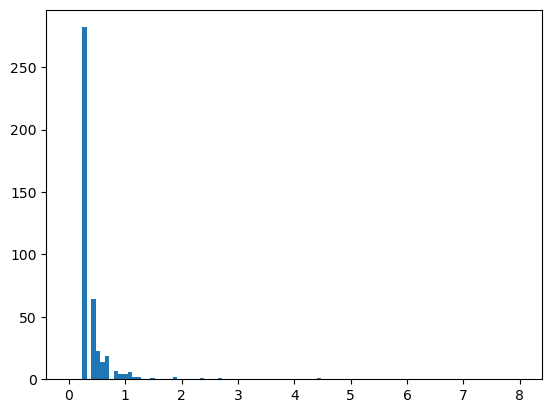

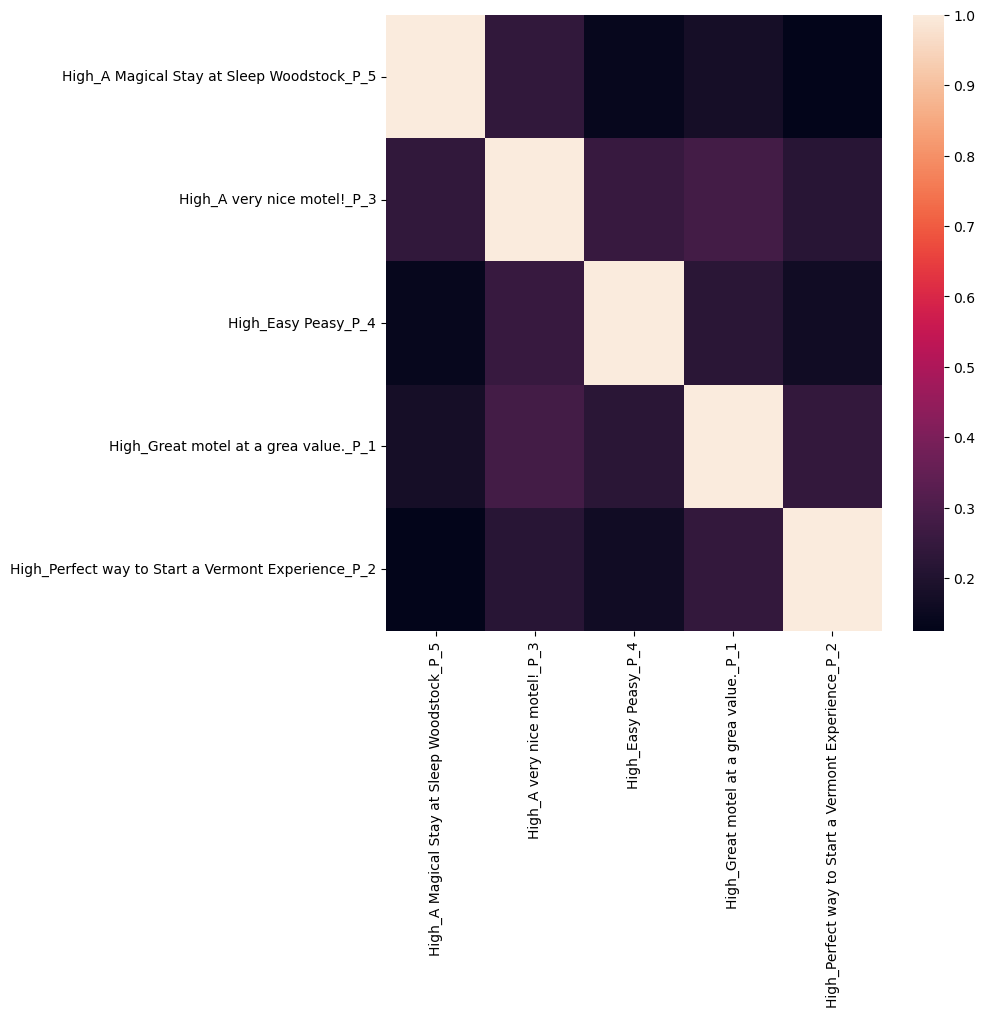

In [29]:
run_tfidf(documents, clean_method, important_prevalent_terms, 'TFIDF_exp')

## Word2Vec

<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

## Utility Functions For Word2Vec Experiments

In [30]:
def get_word2vec_vectors(documents: List[TokenizedDocument], embedding_size: int) -> pd.DataFrame:
    tokens = [x.tokens for x in documents]

    word2vec_model = Word2Vec(sentences=tokens, vector_size=embedding_size, window=3, min_count=1, workers=12)

    vectors = {}
    for i in word2vec_model.wv.index_to_key:
        temp_vec = word2vec_model.wv[i]
        vectors[i] = temp_vec

    result = pd.DataFrame(vectors).transpose()
    result = result.sort_index()
    return result

def plot_similarity_matrix(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()

def plot_similarity_clustermap(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

def plot_tsne(data: pd.DataFrame, perplexity: int, experiment_name: str, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]

        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()

def run_word2vec_experiment(documents: List[Document],
                            clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                            embedding_size: int,
                            chosen_tokens: List[str],
                            experiment_name: str):
    cleaned_documents = clean_func(documents)

    word2vec_df = get_word2vec_vectors(cleaned_documents, embedding_size)
    #print(word2vec_df)
    filtered_word2vec_df = word2vec_df.loc[chosen_tokens].copy()
    
    plot_tsne(filtered_word2vec_df, 30, experiment_name)
    plot_similarity_matrix(filtered_word2vec_df, experiment_name)
    plot_similarity_clustermap(filtered_word2vec_df, experiment_name)

In [31]:
extra_terms = [
    'access',
    'work',
    'yellow'
]

In [32]:
# Get our terms to examine in experiements 4-12
all_tokens = get_all_tokens(remove_stop_words(clean_method(documents)))
chosen_tokens = random.choices(all_tokens, k=100 - len(extra_terms)) + extra_terms

lemmatizer = WordNetLemmatizer()
lemmatized_chosen_tokens = [lemmatizer.lemmatize(x) for x in chosen_tokens]
stemmed_chosen_tokens = [stemmer.stem(x) for x in lemmatized_chosen_tokens]

## Word2Vec Experiments:


<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

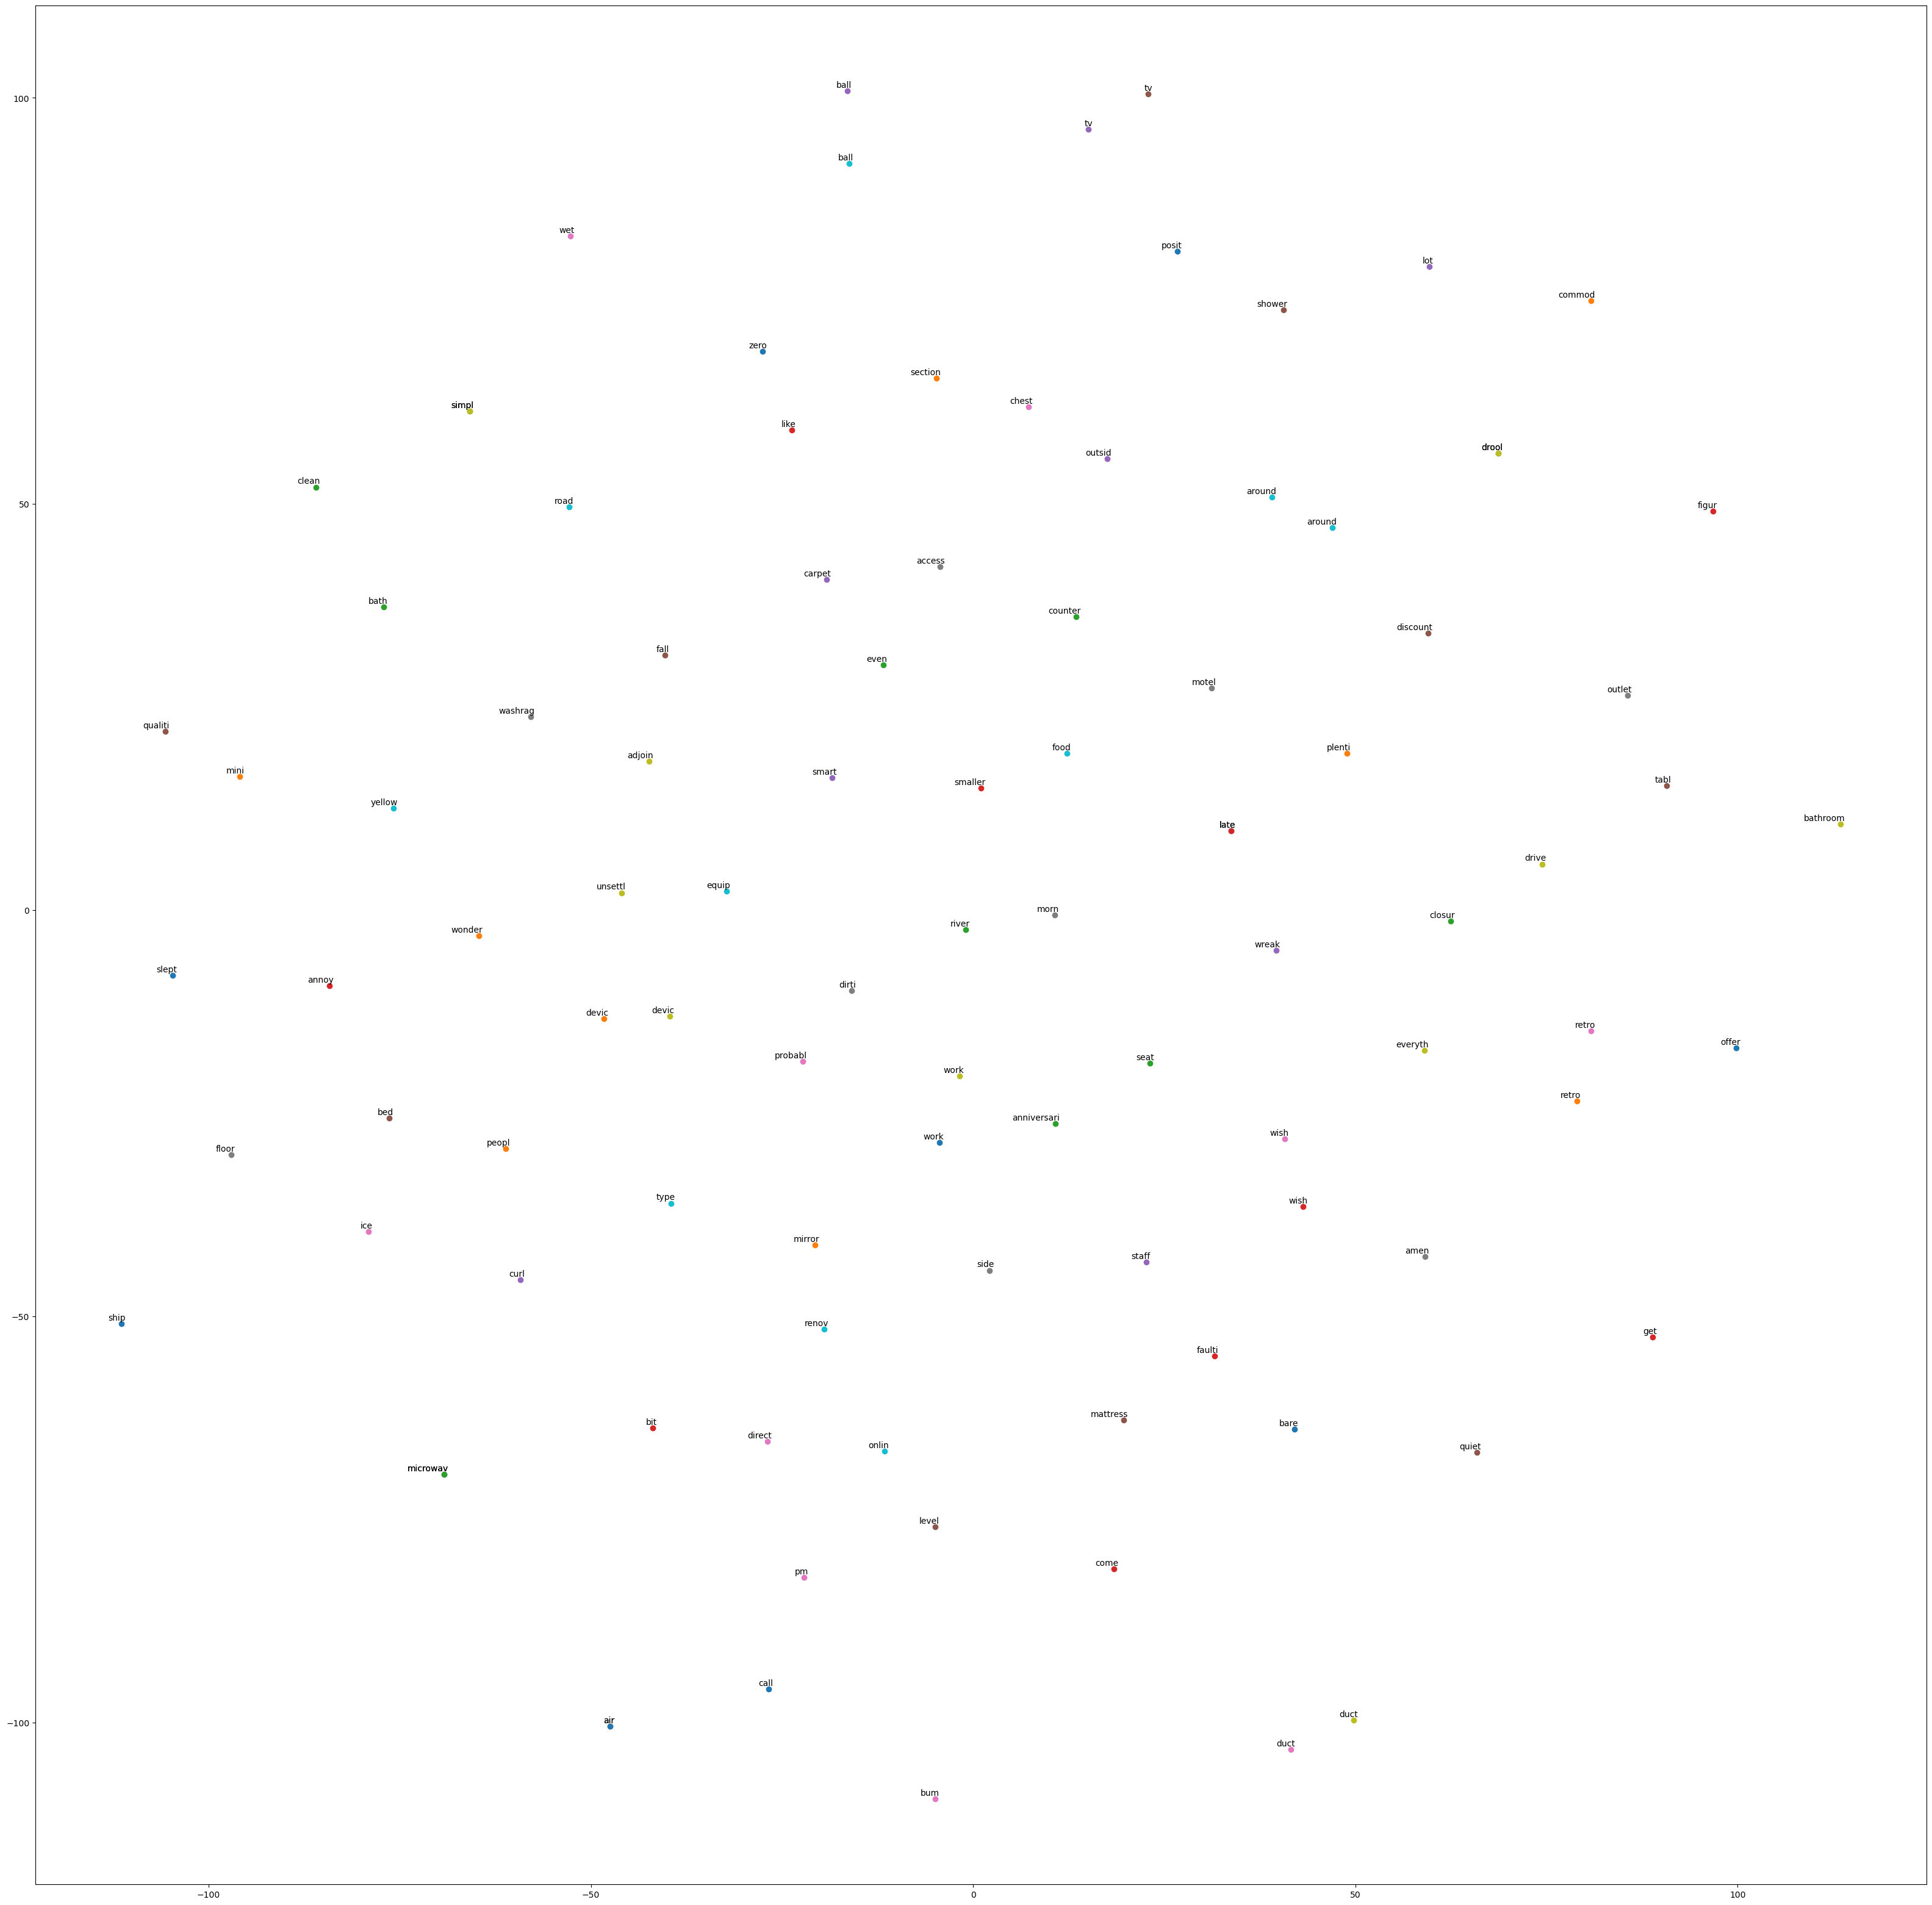

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


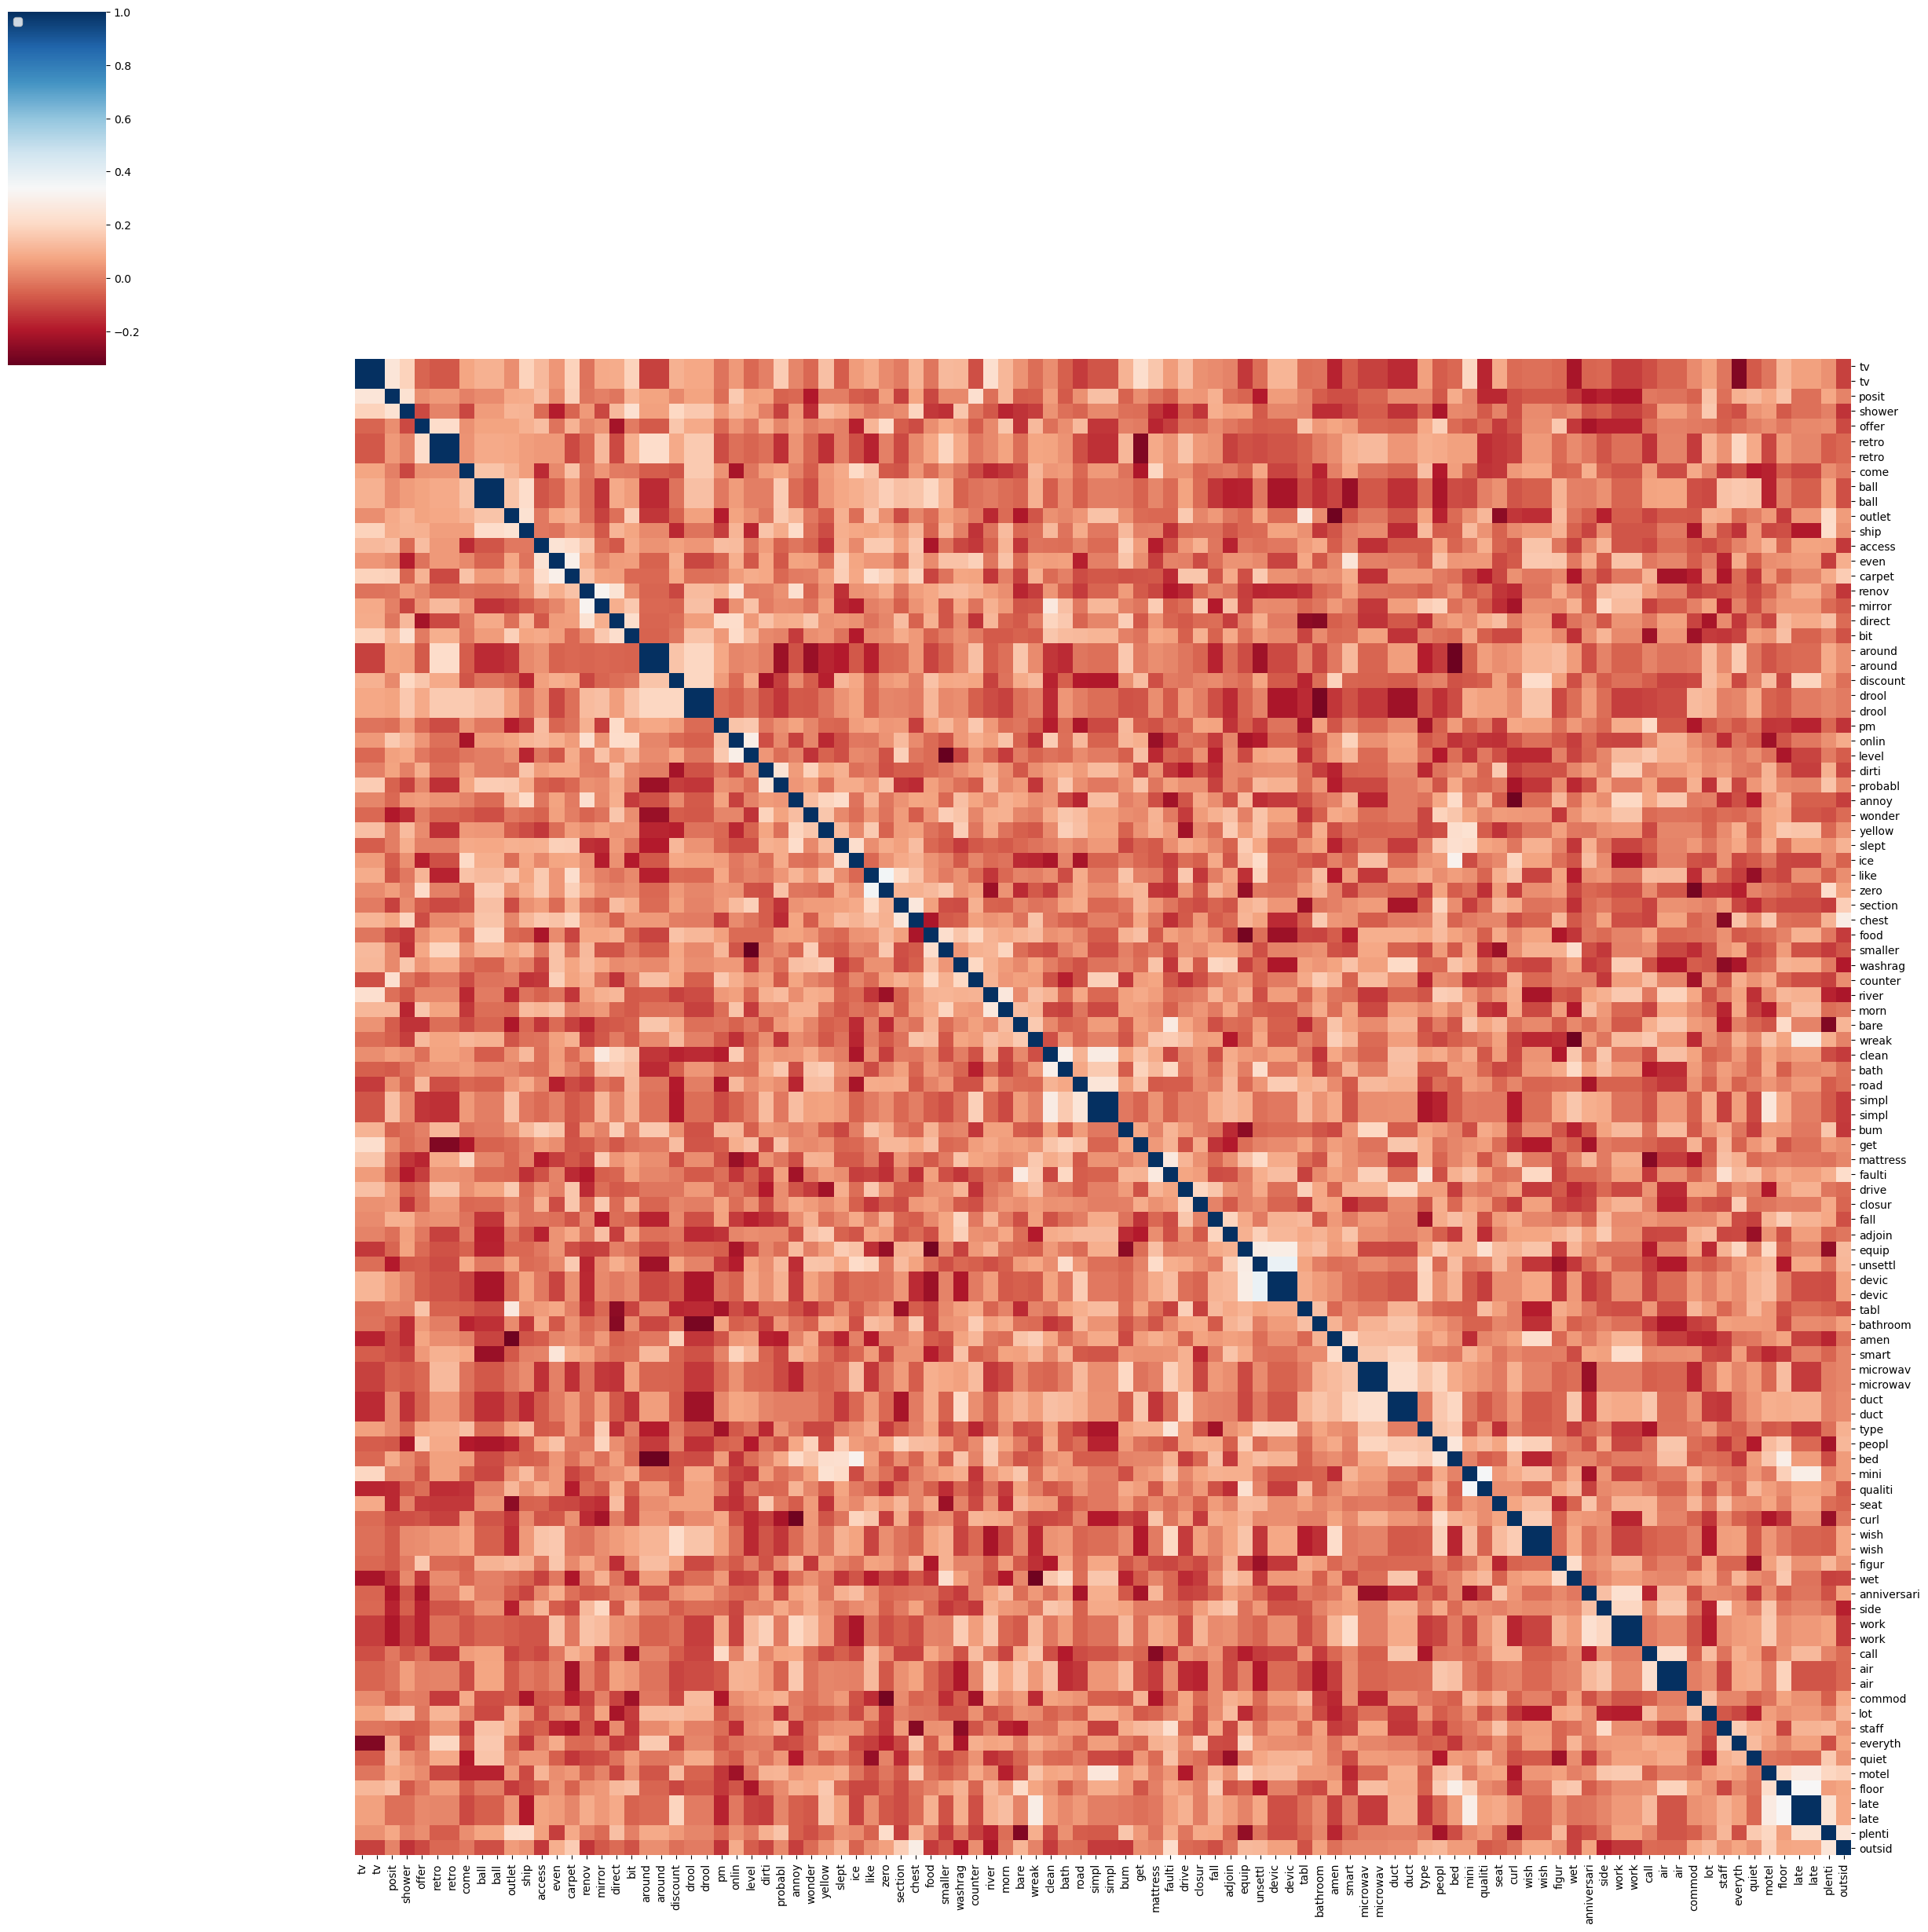

In [33]:
run_word2vec_experiment(documents, clean_method, 100, chosen_tokens, 'Word2Vec_exp')

## Utility functions for Doc2Vec experiments

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

In [34]:
def run_doc2vec(documents: List[TokenizedDocument], embedding_size: int, descriptors_by_doc_ids: Dict[int, str]):
    tagged_documents = [TaggedDocument(document.tokens, [i]) for i, document in enumerate(documents)]
    doc2vec_model = Doc2Vec(tagged_documents, vector_size=embedding_size, window=3, min_count=2, workers=12)

    doc2vec_df = pd.DataFrame()
    for document in documents:
        vector = pd.DataFrame(doc2vec_model.infer_vector(document.tokens)).transpose()
        doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)

    doc2vec_df['Descriptor'] = [descriptors_by_doc_ids[x.doc_id] for x in documents]
    doc2vec_df.set_index(['Descriptor'], inplace=True)
    return doc2vec_df

def run_doc2vec_experiment(documents: List[Document],
                           clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                           embedding_size: int,
                           experiment_name: str):
    cleaned_documents = clean_func(documents)
    doc2vec_df = run_doc2vec(cleaned_documents, embedding_size, descriptors_by_doc_ids)

    plot_similarity_matrix(doc2vec_df, experiment_name)
    plot_similarity_clustermap(doc2vec_df, experiment_name, figsize=(50, 50))
    plot_tsne(doc2vec_df, 9, experiment_name)

## Doc2Vec Experiments:

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


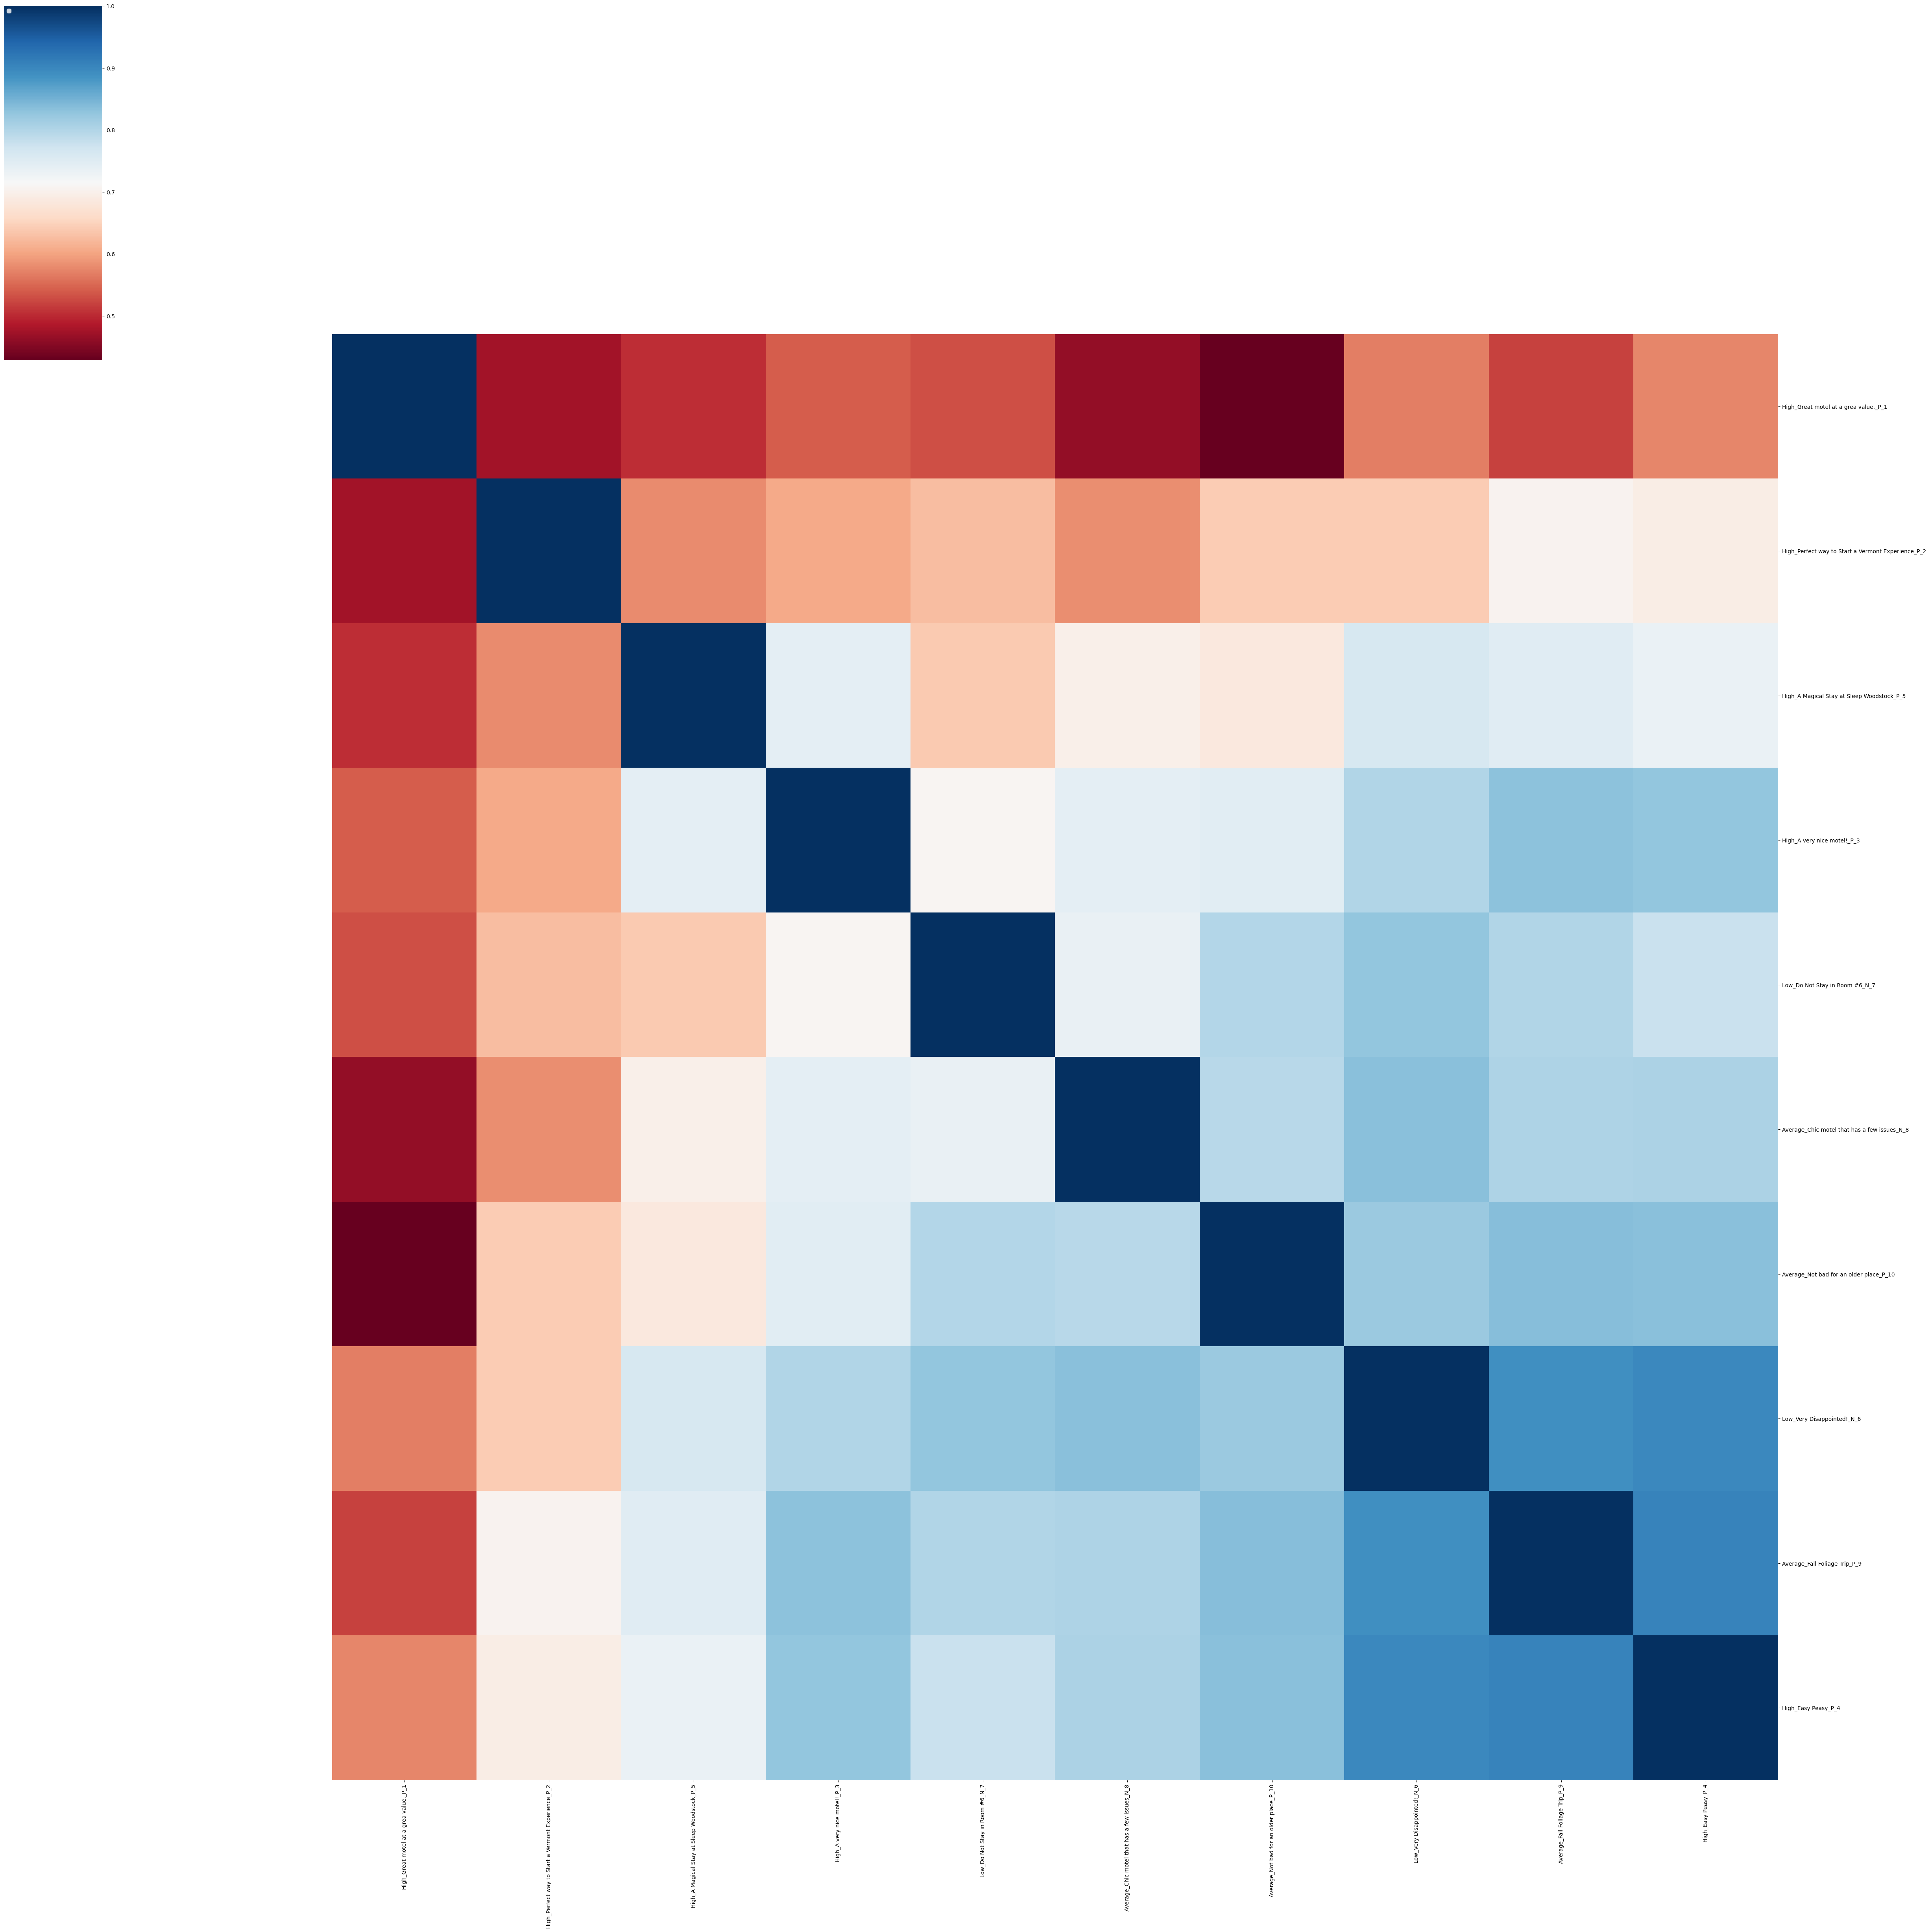

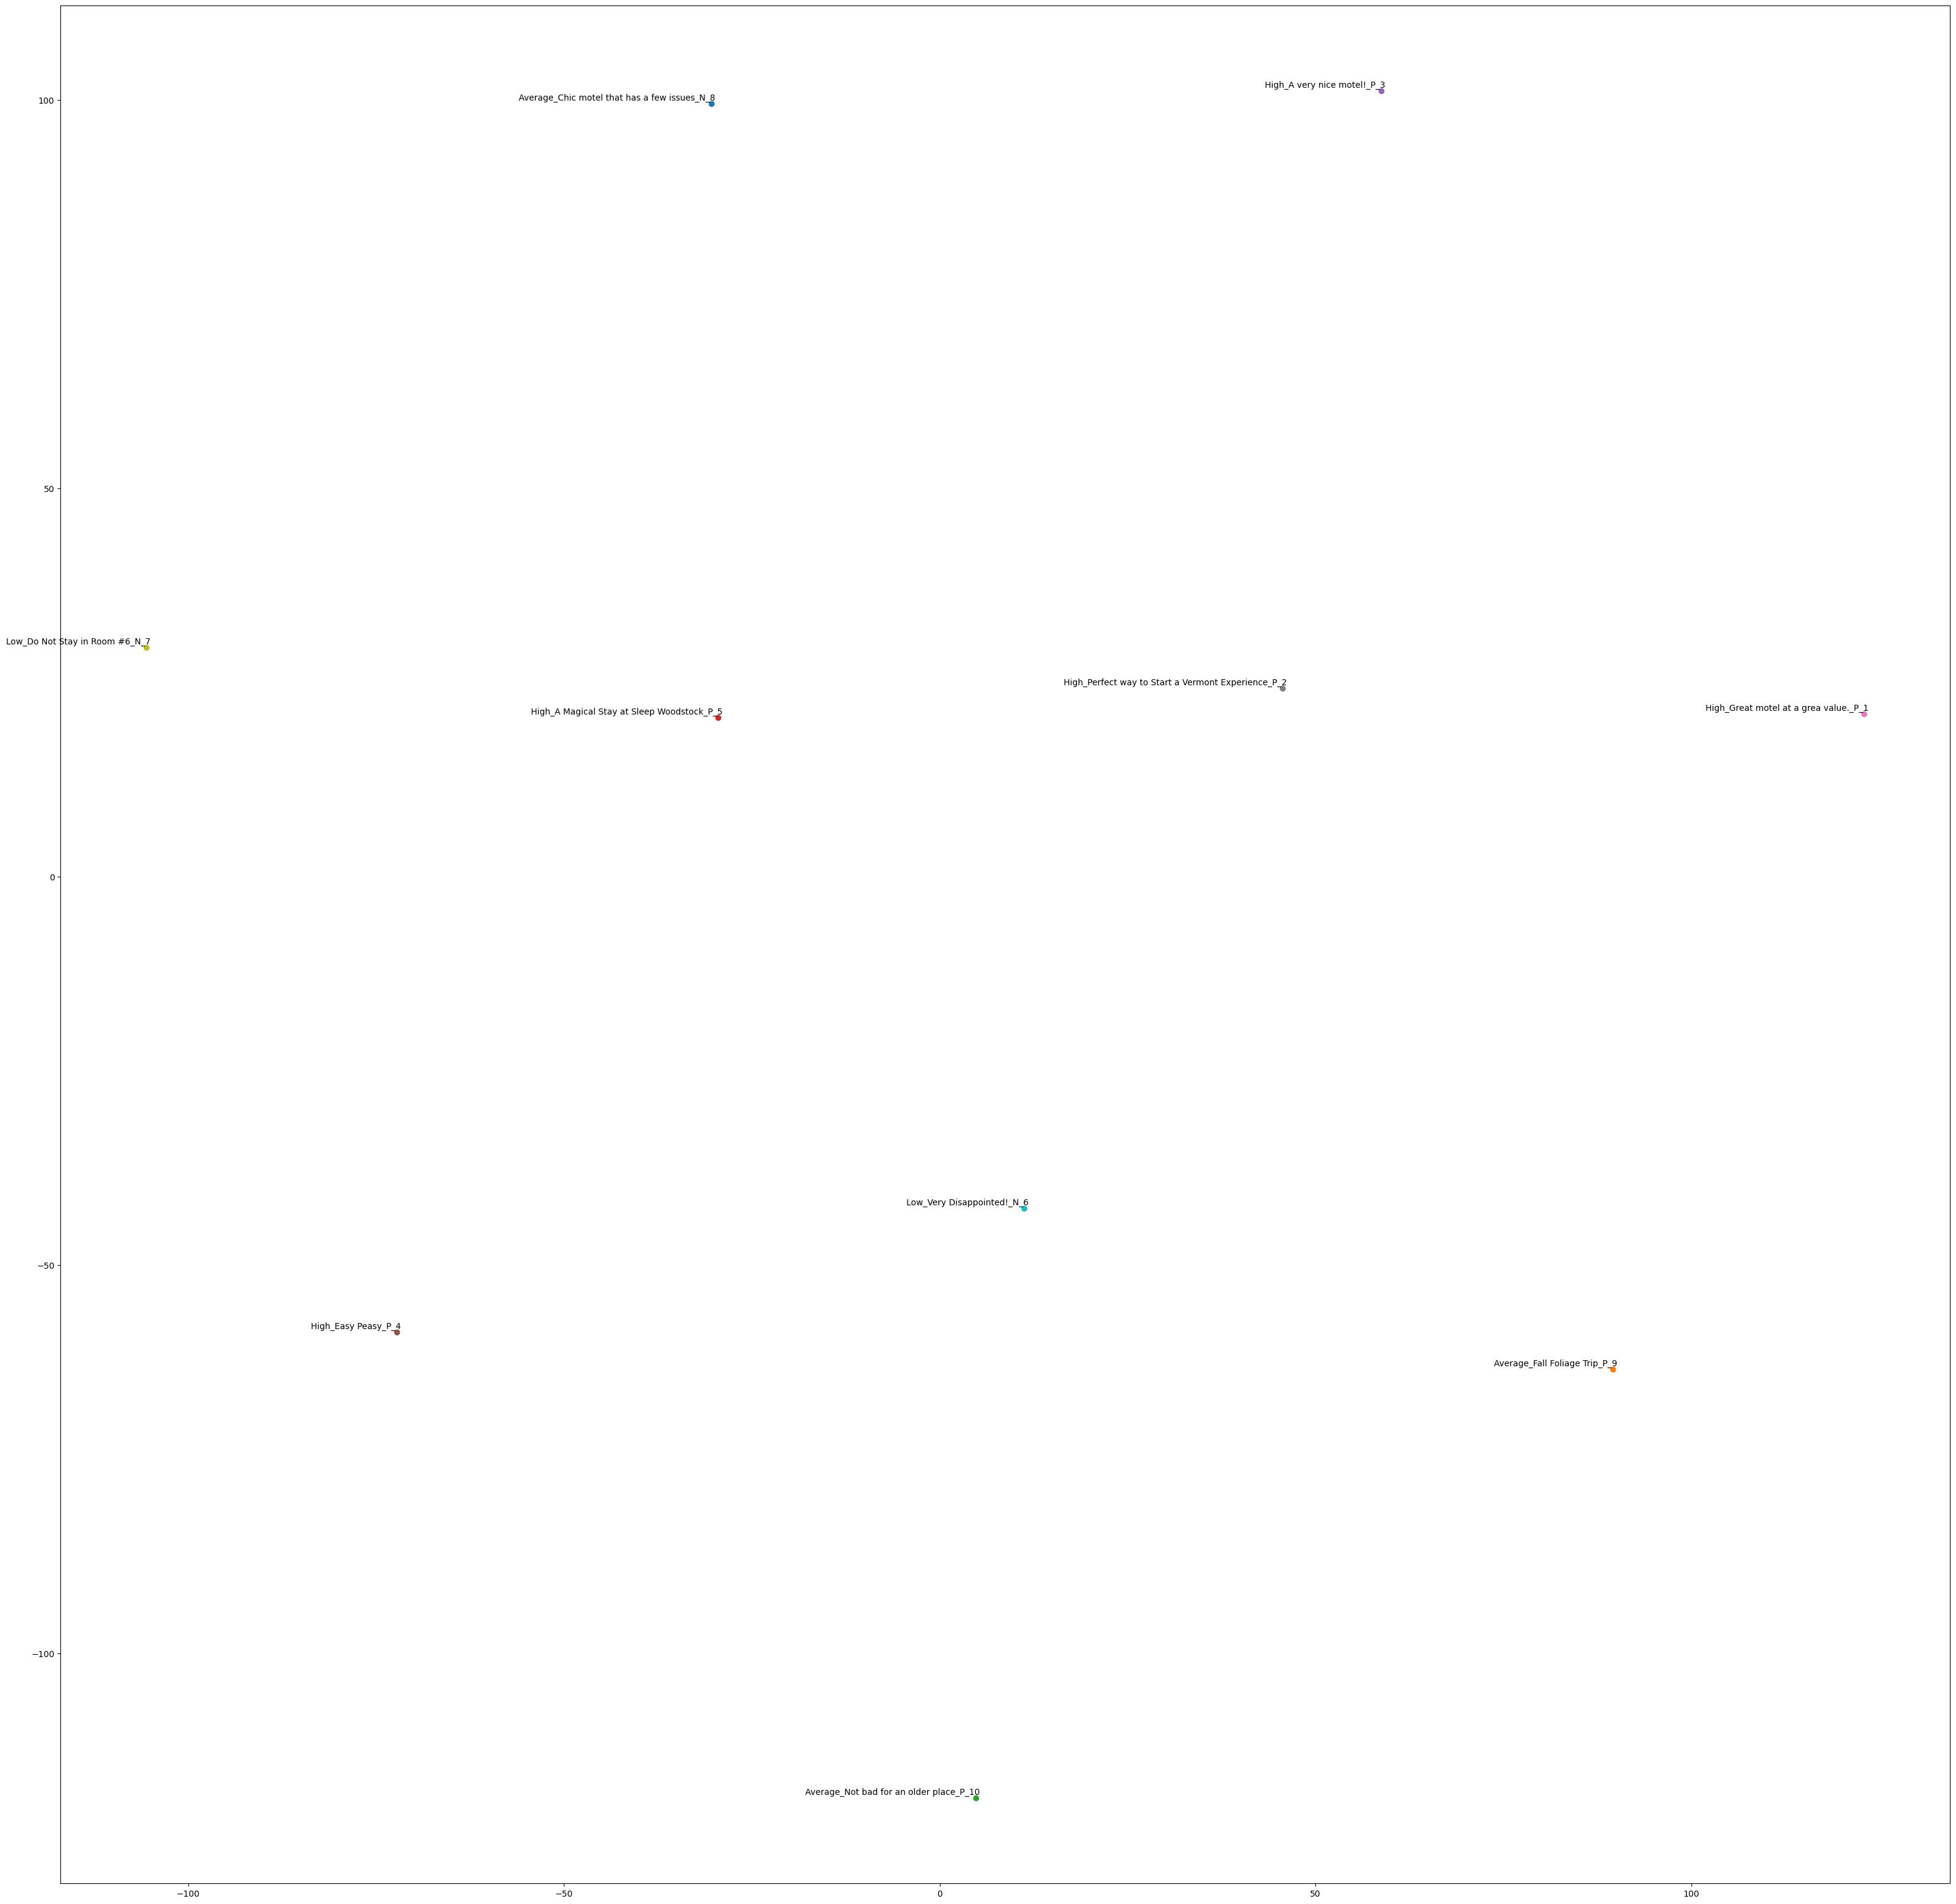

In [35]:
run_doc2vec_experiment(documents, clean_method, 100, 'Doc2Vec_exp')

## **ELMO Emeddings**

Explore ELMo (Embeddings from Language Models) embeddings to enhance our text analysis capabilities. Unlike traditional word embeddings that represent words with static vectors, ELMo provides context-aware embeddings, capturing the nuanced meanings of words based on their usage.

This is a TensorFlow 1 version of ELMo, available at Kaggle https://www.kaggle.com/models/google/elmo/frameworks/tensorFlow1/variations/elmo/versions/3 , compatible with modern Python environments, and we use TensorFlow 2 code instead.

In [36]:
# TENSOR FLOW 2.x VARIATION

# Load the ELMo model
elmo = hub.load("https://tfhub.dev/google/elmo/3")
embeddings = elmo.signatures['default'](tf.constant(["I have a pen", "I have an apple"]))['elmo']


In [37]:
def get_elmo_embeddings(texts):
    """
    Generate ELMo embeddings for a list of texts.

    Parameters:
    - texts: List of strings

    Returns:
    - A Tensor containing the ELMo embeddings for the input texts.
    """
    # Convert texts to TensorFlow constants
    text_tf = tf.constant(texts)

    # Generate ELMo embeddings
    embeddings = elmo.signatures['default'](text_tf)['elmo']

    return embeddings

In [38]:
#documents

In [39]:
# NO DATA WRANGLING
texts = corpus_df['Review'].tolist()

# OR UNCOMMENT FOR DATA WRANGLING
#cleaned_documents = clean_method(documents)
#texts = [' '.join(x.tokens) for x in cleaned_documents]


In [40]:
# Process in batches to manage memory usage
batch_size = 4
# Start with a smaller batch size to monitor performance
# 4 works in Google Collab

all_embeddings = []

# GET ELMO EMBEDDINGS OVER A SUBSET OF ALL MOVIE REVIEWS
sample_size=10

# OR UNCOMMENT TO RUN FOR ALL MOVIE REVIEWS
# Note: Processing all reviews takes over 30 minutes to run.
#sample_size= len(texts)


for i in range(0, sample_size, batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_embeddings = get_elmo_embeddings(batch_texts)
    all_embeddings.append(batch_embeddings)
    print(f"Processed batch {i//batch_size + 1}/{len(texts)//batch_size + 1}")


Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


In [41]:
# Convert the list of tensors to a single numpy array
all_embeddings_np = np.concatenate([batch.numpy().mean(axis=1) for batch in all_embeddings], axis=0)


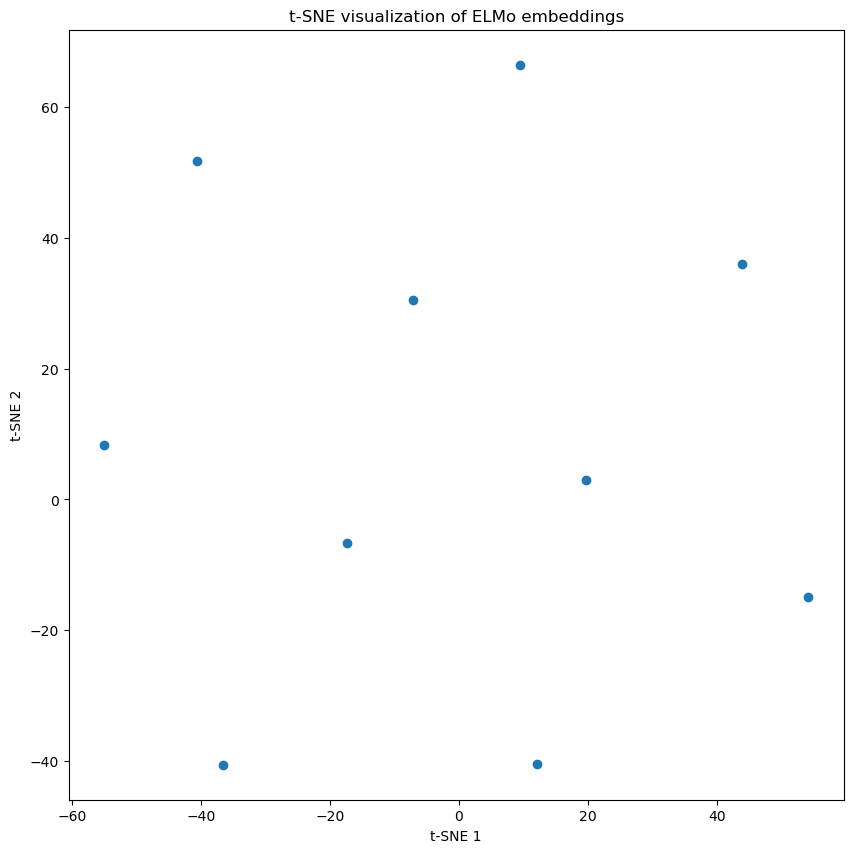

In [42]:
# Use t-SNE to reduce dimensionality for visualization
if (sample_size>=30):
    tsne = TSNE(n_components=2, random_state=42)
else:
    # Default perplexity is too large for a small sample size
    tsne = TSNE(n_components=2, random_state=42, perplexity=sample_size-1)

embeddings_tsne = tsne.fit_transform(all_embeddings_np)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title('t-SNE visualization of ELMo embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


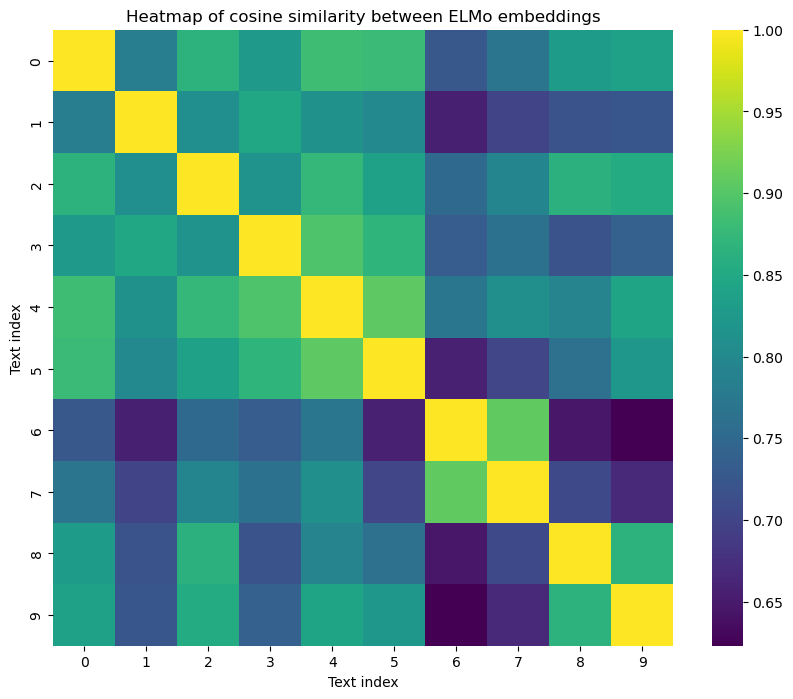

In [43]:
# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(all_embeddings_np)

# Plot as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Heatmap of cosine similarity between ELMo embeddings')
plt.xlabel('Text index')
plt.ylabel('Text index')
plt.show()
